# **Classification**

    Notebook version: 1.0 (Nov 11, 2015)

    Authors: Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Changes: v.1.0 - First version. Python version

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib notebook 

#import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm, cross_validation

import pylab
pylab.rcParams['figure.figsize'] = 9, 7

/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Introduction

In this notebook we will analyze the behavior of logistic regression and support vector machines on the `cancer` dataset, taken from the <a href = https://archive.ics.uci.edu/ml/index.html>UCI repository </a>. You can load it from from file `CancerDataset.mat`. 

### 1.1 Data Preparation.

Load and normalize the dataset. Remind that the same transformation must be applied to training, validation and test data.

In [2]:
# Data normalization
def normalize(X, mx=None, sx=None):
    
    # Compute means and standard deviations
    if mx is None:
        mx = np.mean(X, axis=0)
    if sx is None:
        sx = np.std(X, axis=0)

    # Normalize
    X0 = (X-mx)/sx

    return X0, mx, sx

# Load dataset
matvar = scipy.io.loadmat('CancerDataset.mat')
Xtrain = matvar['xTrain']
Xtest = matvar['xTest']
Xval = matvar['xVal']
Ytrain = matvar['yTrain']
Ytest = matvar['yTest']
Yval = matvar['yVal']

#print matvar.keys()
#x = matvar['cancerInputs']
#y = matvar['cancerTargets']

#print x.shape
#print y.shape
#x = cancerInputs';
#y = cancerTargets(2,:)';

# Normalize data
Xtrain, mx, sx = normalize(Xtrain)
Xval, mx, sx = normalize(Xval, mx, sx)
Xtest, mx, sx = normalize(Xtest, mx, sx)

n_tr = Xtrain.shape[0]
n_val = Xval.shape[0]
n_tst = Xtest.shape[0]

print 'The number of training samples is ' + str(n_tr)
print 'The number of validation samples is ' + str(n_val)
print 'The number of test samples is ' + str(n_tst)
print 'The data dimension is ' + str(Xtrain.shape[1])

# Check normalization
print np.mean(Xtrain, axis=0)
print np.mean(Xval, axis=0)
print np.mean(Xtest, axis=0)
print np.std(Xtrain, axis=0)
print np.std(Xval, axis=0)
print np.std(Xtest, axis=0)

The number of training samples is 400
The number of validation samples is 400
The number of test samples is 400
The data dimension is 2
[ -3.24185123e-16   2.84217094e-16]
[-0.00966556  0.03965134]
[ 0.00125431  0.02832642]
[ 1.  1.]
[ 0.98064167  1.02630613]
[ 0.9809003   1.03485737]


<IPython.core.display.Javascript object>


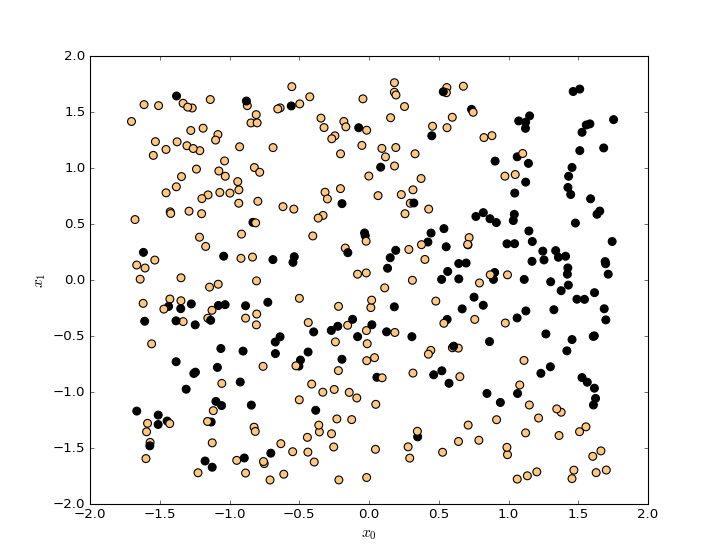

In [3]:
# Data visualization. This works for dimension 2 only.
if Xtrain.shape[1]==2:
    plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain, s=50, cmap='copper')
    plt.xlabel("$x_0$", fontsize=14)
    plt.ylabel("$x_1$", fontsize=14)

## 2. Linear Classification with Logistic Regression.

First we will analyze the behavior of logistic regression for this dataset. 

### 2.1. MAP estimator.

Implement a function to compute the MAP estimate of the parameters of a linear logistic regression model with gaussian prior and a given values of the inverse regularization parameter $C$. The method should return the estimated parameter and the negative log-likelihood, $L({\bf w})$. The sintaxis must be
    **`w, L = logregFitR(Z_tr, Y_tr, rho, C, n_it)`**
where

  - `Z_tr` is the input training data matrix (one instance per row)
  - `Y_tr` contains the labels of corresponding to each row in the data matrix
  - `rho` is the learning step
  - `C` is the inverse regularizer
  - `n_it` is the number of iterations


In [4]:
# Define the logistic function
def logistic(x):                                        
   p = 1.0 / (1 + np.exp(-x))
   return p

# MAP trainer.
def logregFitR(Z_tr, Y_tr, rho, C, n_it):

    # Data dimension
    n_dim = Z_tr.shape[1]

    # Initialize variables
    nll_tr = np.zeros(n_it)
    pe_tr = np.zeros(n_it)
    w = np.random.randn(n_dim,1)

    # Running the gradient descent algorithm
    for n in range(n_it):
        
        # Compute posterior probabilities for weight w
        p1_tr = logistic(np.dot(Z_tr, w))
        p0_tr = logistic(-np.dot(Z_tr, w))
        
        # Compute negative log-likelihood
        nll_tr[n] = - np.dot(Y_tr.T, np.log(p1_tr)) - np.dot((1-Y_tr).T, np.log(p0_tr))

        # Update weights
        w = (1-2*rho/C)*w + rho*np.dot(Z_tr.T, Y_tr - p1_tr)

    return w, nll_tr

# Compute predictions for a given model
def logregPredict(Z, w):

    # Compute posterior probability of class 1 for weights w.
    p = logistic(np.dot(Z, w))
    
    # Classify
    D = [int(round(pn)) for pn in p]
    
    return p, D

### 2..2 Log-likelihood

Compute the MAP estimate for a polynomial regression with degree 5, for $C$ ranging from -0.05 to 10. Sample $C$ uniformly in a log scale, an plot using `plt.semilogx`. 

Plot the final value of $L$ as a function of $C$. Can you explain the qualitative behavior of $L$ as $C$ grows?

The plot may show some oscillation because of the random noice introduced by random initializations of the learning algoritm. In order to smooth the results, you can initialize the random seed right before calling the `logregFitR` method, using

    np.random.seed(3)


<IPython.core.display.Javascript object>


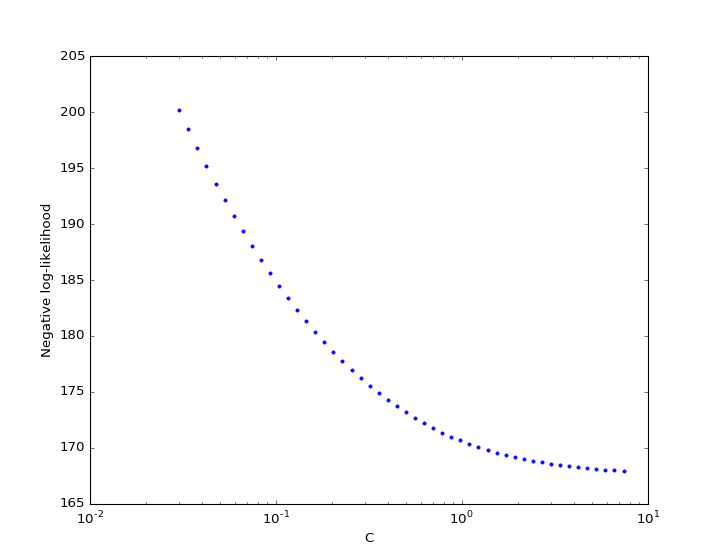

As C grows, the regularization effect dissapears, and the fit method minimizes L.


In [5]:
# Set parameters
nC = 50

logC = np.linspace(-3.5, 2, num=nC)
C_all = np.exp(logC)
n_it = 2000
rho = 0.001

# Compute Z_tr
poly = PolynomialFeatures(degree=5)
Z_tr = poly.fit_transform(Xtrain)

# Normalize columns (this is useful to make algorithms more stable).)
Zn, mz, sz = normalize(Z_tr[:,1:])
Z_tr = np.concatenate((np.ones((n_tr, 1)), Zn), axis=1)

# Compute Z_val
Z_val = poly.fit_transform(Xval)
Zn, mz, sz = normalize(Z_val[:,1:], mz, sz)
Z_val = np.concatenate((np.ones((n_val,1)), Zn), axis=1)

dim = Z_tr.shape[1]
L = np.zeros((nC, 1))
w_all = np.zeros((nC, dim))

# Train models
for k, C in enumerate(C_all):
    
    np.random.seed(3)
    w, L_all = logregFitR(Z_tr, Ytrain, rho, C, n_it)

    L[k] = L_all[-1]
    w_all[k] = w.T

plt.figure()
plt.semilogx(C_all, L, '.')
plt.xlabel('C')
plt.ylabel('Negative log-likelihood')

print "As C grows, the regularization effect dissapears, and the fit method minimizes L."

<IPython.core.display.Javascript object>


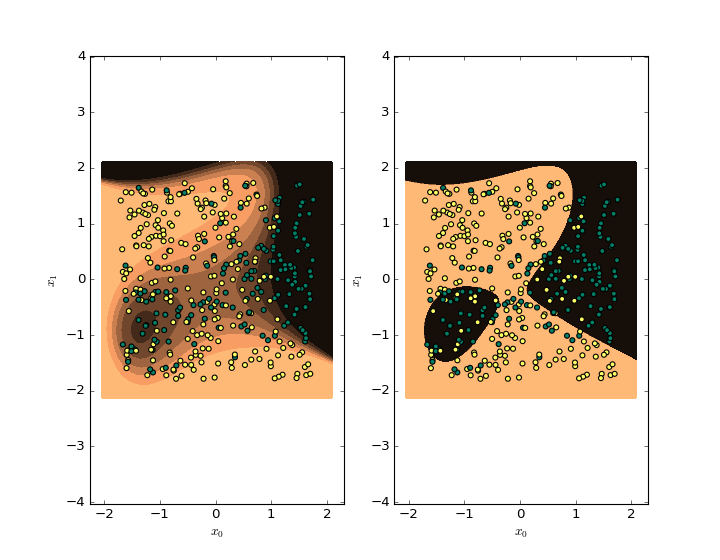

/Users/jcid/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [6]:
# This is a plot for the last value of C used in the code above.
plt.figure()
if Xtrain.shape[1]==2:
    # Create a regtangular grid.
    x_min, x_max = Xtrain[:, 0].min(), Xtrain[:, 0].max() 
    y_min, y_max = Xtrain[:, 1].min(), Xtrain[:, 1].max()
    dx = x_max - x_min
    dy = y_max - y_min
    h = dy /400
    xx, yy = np.meshgrid(np.arange(x_min - 0.1 * dx, x_max + 0.1 * dx, h),
                         np.arange(y_min - 0.1 * dx, y_max + 0.1 * dy, h))
    X_grid = np.array([xx.ravel(), yy.ravel()]).T

    # Compute Z_grid
    Z_grid = poly.fit_transform(X_grid)
    n_grid = Z_grid.shape[0]
    Zn, mz, sz = normalize(Z_grid[:,1:], mz, sz)
    Z_grid = np.concatenate((np.ones((n_grid,1)), Zn), axis=1)

    # Compute the classifier output for all samples in the grid.
    pp, dd = logregPredict(Z_grid, w)
    pp = pp.reshape(xx.shape)

    # Paint output maps
    pylab.rcParams['figure.figsize'] = 8, 4  # Set figure size
    for i in [1, 2]:
        ax = plt.subplot(1,2,i)
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.axis('equal')
        if i==1:
            ax.contourf(xx, yy, pp, cmap=plt.cm.copper)
        else:
            ax.legend(loc='best')
            ax.contourf(xx, yy, np.round(pp), cmap=plt.cm.copper)
        ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain, s=20, cmap='summer')

###  2.3. Training and test errors.

Plot the training and validation error rates as a function of $C$. Compute the value of $C$ minimizing the validation error rate.


<IPython.core.display.Javascript object>


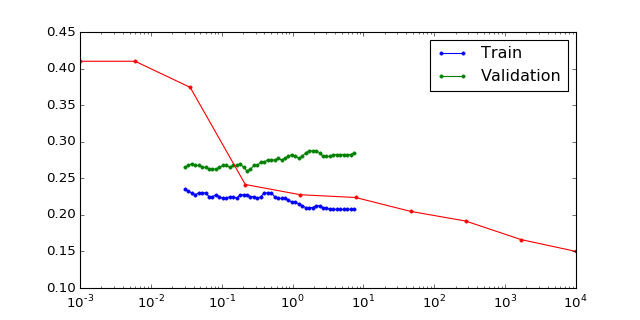

The optimal value of C is  0.22773062069


In [7]:
# Train models
pe_tr = np.zeros((nC, 1))
pe_val = np.zeros((nC, 1))

for k, C in enumerate(C_all):

    p_tr, D_tr = logregPredict(Z_tr, w_all[k])
    p_val, D_val = logregPredict(Z_val, w_all[k])

    # Compute error rates
    E_tr = D_tr!=Ytrain.T
    E_val = D_val!=Yval.T

    # Error rates
    pe_tr[k] = np.mean(E_tr)
    pe_val[k] = np.mean(E_val)

plt.figure()
plt.semilogx(C_all, pe_tr, '.-', label='Train')
plt.semilogx(C_all, pe_val, '.-', label='Validation')
plt.legend(loc='best')

print "The optimal value of C is ",
print C_all[np.argmin(pe_val)]



## 3. Non-linear classification with Support Vector Machines

In this section we will train a SVM with Gaussian kernels. In this case, we will select parameter $C$ of the SVM by cross-validation.

### 3.1. Dataset preparation.

Join the training and validation datasets in a single input matrix `X_tr2` and a single label vector `Y_tr2`

In [8]:
X_tr2 = np.concatenate((Xtrain, Xval), axis = 0)
Y_tr2 = np.concatenate((Ytrain, Yval), axis = 0)

### 3.2. Cross validated error estimate

Apply a 10-fold cross validation procedure to estimate the average error rate of the SVM for $C=1$ and $\gamma$ (which is the kernel width) equal to 5.

In [9]:
n_folds = 10
C = 1
gamma = 5

n_samples = X_tr2.shape[0]
kf = cross_validation.KFold(n_samples, n_folds=n_folds)

pe_val = 0
clf = svm.SVC(kernel='rbf', C=C, gamma=1)
for tr_index, val_index in kf:
    Xcv_tr, Xcv_val = X_tr2[tr_index], X_tr2[val_index]
    Ycv_tr, Ycv_val = Y_tr2[tr_index], Y_tr2[val_index]

    clf.fit(Xcv_tr, np.ravel(Ycv_tr))

    pe_val += 1.0 - clf.score(Xval, Yval)

pe_val = pe_val/len(kf)

print "The average error rate is " + str(pe_val)


The average error rate is 0.24225


### 3.3. Influence of $C$.

Repeate exercise 3.2 for $\gamma=5$ and different values of $C$, ranging from $10^{-3}$ to $10^{4}$, obtained by uniform sampling in a logarithmic scale. Plot the average number of errors as function of $C$.

Note that fitting the SVM may take some time, specially for the largest values of $C$.

In [10]:
C_all = np.logspace(-3, 4, 10)

n_samples = X_tr2.shape[0]
kf = cross_validation.KFold(n_samples, n_folds=10)

gamma = 5
pe_val = np.zeros((len(C_all),1))

for k, C in enumerate(C_all):
    print C

    clf = svm.SVC(kernel='rbf', C=C, gamma=gamma)

    for tr_index, val_index in kf:
        Xcv_tr, Xcv_val = X_tr2[tr_index], X_tr2[val_index]
        Ycv_tr, Ycv_val = Y_tr2[tr_index], Y_tr2[val_index]

        clf.fit(Xcv_tr, np.ravel(Ycv_tr))

        pe_val[k] += 1.0 - clf.score(Xval, Yval)

    pe_val[k] = pe_val[k]/len(kf)

# Put the result into a color plot
plt.semilogx(C_all, pe_val,'.-')

0.001
0.00599484250319
0.035938136638
0.215443469003
1.29154966501
7.74263682681
46.4158883361
278.255940221
1668.1005372
10000.0


### 3.3. Hyperparameter optimization.

Compute the value of $C$ minimizing the validation error rate.

In [11]:
C_opt = C_all[np.argmin(pe_val)]
print "The optimal value of C in the explored range is " + str(C_opt)

The optimal value of C in the explored range is 10000.0


### 3.4. Test error

Evaluate the classifier performance using the test data, for the selected hyperparameter values.


In [12]:
clf = svm.SVC(kernel='rbf', C=C_opt, gamma=gamma)
clf.fit(X_tr2, np.ravel(Y_tr2))
pe_tst = 1.0 - clf.score(Xtest, Ytest)
print "The test error for the selected model is " +  str(pe_tst)

The test error for the selected model is 0.33
